# Chapter 2 : Movie Plot Summary Analysis
`Revenue prediction` `LDA` `Topic Modelling` `XGBoost` `Genre prediction` `Word Embedding` `Neural Net` `Web Scraping` `Beautiful Soup` `merged models`


**Author** : Antarlina Mukherjee

### Report Approach and Research questions:
The first part of the report includes data exploration and visualizations and making observations. All the data preparation for the subsequent research questions are done in this phase. The research questions explored in this report are: <br>

   - Possibility of predicting genre tags from movie plot summaries
   - Possibility of predicting movie revenue based on genre tags, and other attributes

Most of the bulky code has been moved out of this report into another jupyter notebook called *EDA_Functions.ipynb*.
Some data cleaning codes which take ~30 mins to run have been saved in an excel file and referenced through import( code pertaining to the creation of those has been shared albeit commented out) and also shared with this notebook. Certain data summaries have also been provided in excel (for example, for ~300 genres) for ease of reference and will be mentioned in the course of reading the report. Parameter tuning of models was performed separately and the final values have been chosen for presenting in the report. Methods explored which did not give good results (such as the LDA) were not diagnosed in detail.

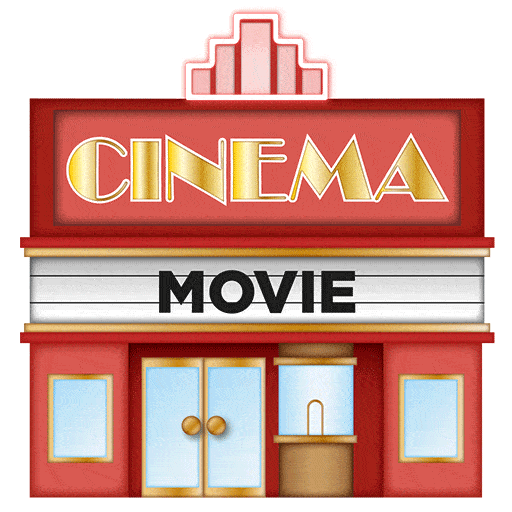

In [74]:
%run EDA_Functions.ipynb
from IPython import display ;
display.Image("move_theater.gif",width = 600, height = 2)

 This chapter is based on plot summaries data available from [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). It contains plot summaries 42,306 movies along with other attributes such as `movie title`, `release date`, `runtime`, `plot summary` and `Box Office revenue` ,`genre`, `country`, `language` among others (refer to README attached for details). One movie can belong to multiple genres. An additional dataset is available with information about actors in the movie. It includes attributes such as `actor name`, `gender`, `age of actor while release` etc. Following is the first record of the dataset and the spread of movies over the years

## Importing files and cleanup

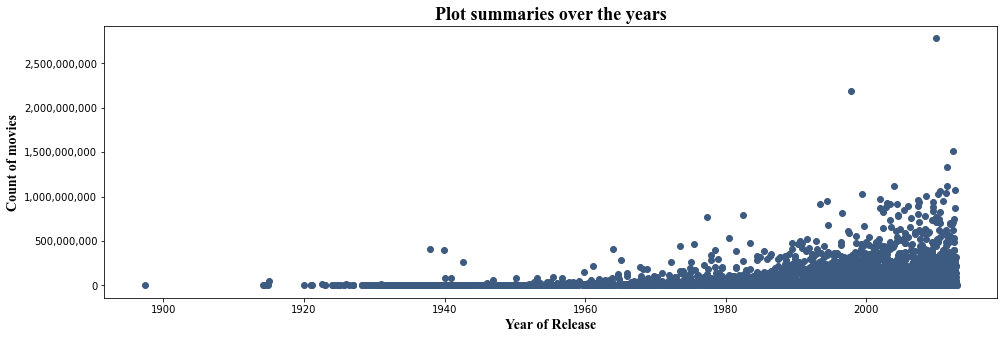

                                                              0
wiki_id                                                  975900
freebase_id                                           /m/03vyhn
title                                            Ghosts of Mars
release_date                                2001-08-24 00:00:00
BO_revenue                                           14010832.0
runtime                                                    98.0
languages                    {"/m/02h40lc": "English Language"}
countries             {"/m/09c7w0": "United States of America"}
genres        {"/m/01jfsb": "Thriller", "/m/06n90": "Science...


,count,mean,std,min,25%,50%,75%,max
wiki_id,81741.0,1.740784e+07,1.098791e+07,330.0,7323695.0,17778990.0,27155727.0,3.750192e+07
BO_revenue,8401.0,4.799363e+07,1.121753e+08,10000.0,2083193.0,10639686.0,40716963.0,2.782275e+09
runtime,61291.0,1.118192e+02,4.360070e+03,0.0,81.0,93.0,106.0,1.079281e+06


In [31]:
summary_meta = pd.read_csv(r"C:\Users\Antarlina Mukherjee\Documents\Studies\Sem 3\4. Advanced Business Analytics\Amazon\summary\MovieSummaries\movie.metadata.tsv",sep='\t',header=None,
                           names=['wiki_id','freebase_id','title','release_date','BO_revenue','runtime','languages','countries','genres'])
view_movie_spread_over_years(summary_meta)
print(summary_meta.head(n=1).T)
summary_meta.describe().T

The data appears to range from **1920 to 2017**.
It is seen that BO_revenue, runtime, release_date have missing values. As the revenue would be very important for the analysis, the website [BoxOfficeMojo](https://www.boxofficemojo.com/) is scraped to pull movie level information from years from 1950 to 2017. Commented code below can be executed. For now, a data dump has been taken and read from for the subsequent analysis. This is followed by cleaning up the titles of both the datasets as there is no other joining key.

In [32]:
# df_list_1 = read_from_mojo(1950,2017)
# df_list_1.to_csv("bomojo.txt")
df_list_1= pd.read_csv("bomojo.csv",encoding='utf-8')
print("Number of movies scraped: ",len(df_list_1))
summary_meta['title_clean']=summary_meta['title'].apply(text_processing)
df_list_1['title_clean']=df_list_1['title'].apply(text_processing)
print(summary_meta['title'].iloc[3],"---------------------->",summary_meta['title_clean'].iloc[3])

Number of movies scraped:  7027
White Of The Eye ----------------------> white of the eye


The two tables are joined and a new column `Final Revenue` is created where missing revenue from CMU data is imputed with BoxOfficeMojo revenue. <br>
Let's see if scraping the was worth the effort !

In [33]:
summary_meta33 = clean_summary_meta(summary_meta,df_list_1)
summary_meta33.describe().T

,count,mean,std,min,25%,50%,75%,max
wiki_id,74391.0,1.749746e+07,1.095368e+07,330.0,7497912.5,17971369.0,27229435.00,3.750192e+07
runtime,74391.0,8.441985e+01,3.957883e+03,0.0,0.0,86.0,100.00,1.079281e+06
final_revenue,8742.0,4.281150e+07,9.916566e+07,8736.0,2250000.0,10338870.0,37786486.25,2.782275e+09


There missing count in the newly computed column is ~1500 lower than BO revenue, not too bad :) 

## EDA: Creating flags for genre, country and languages
Genre, country and languages are maintained as dicts in the data. They are extracted and converted in binary flags 

Number of unique genres:  363


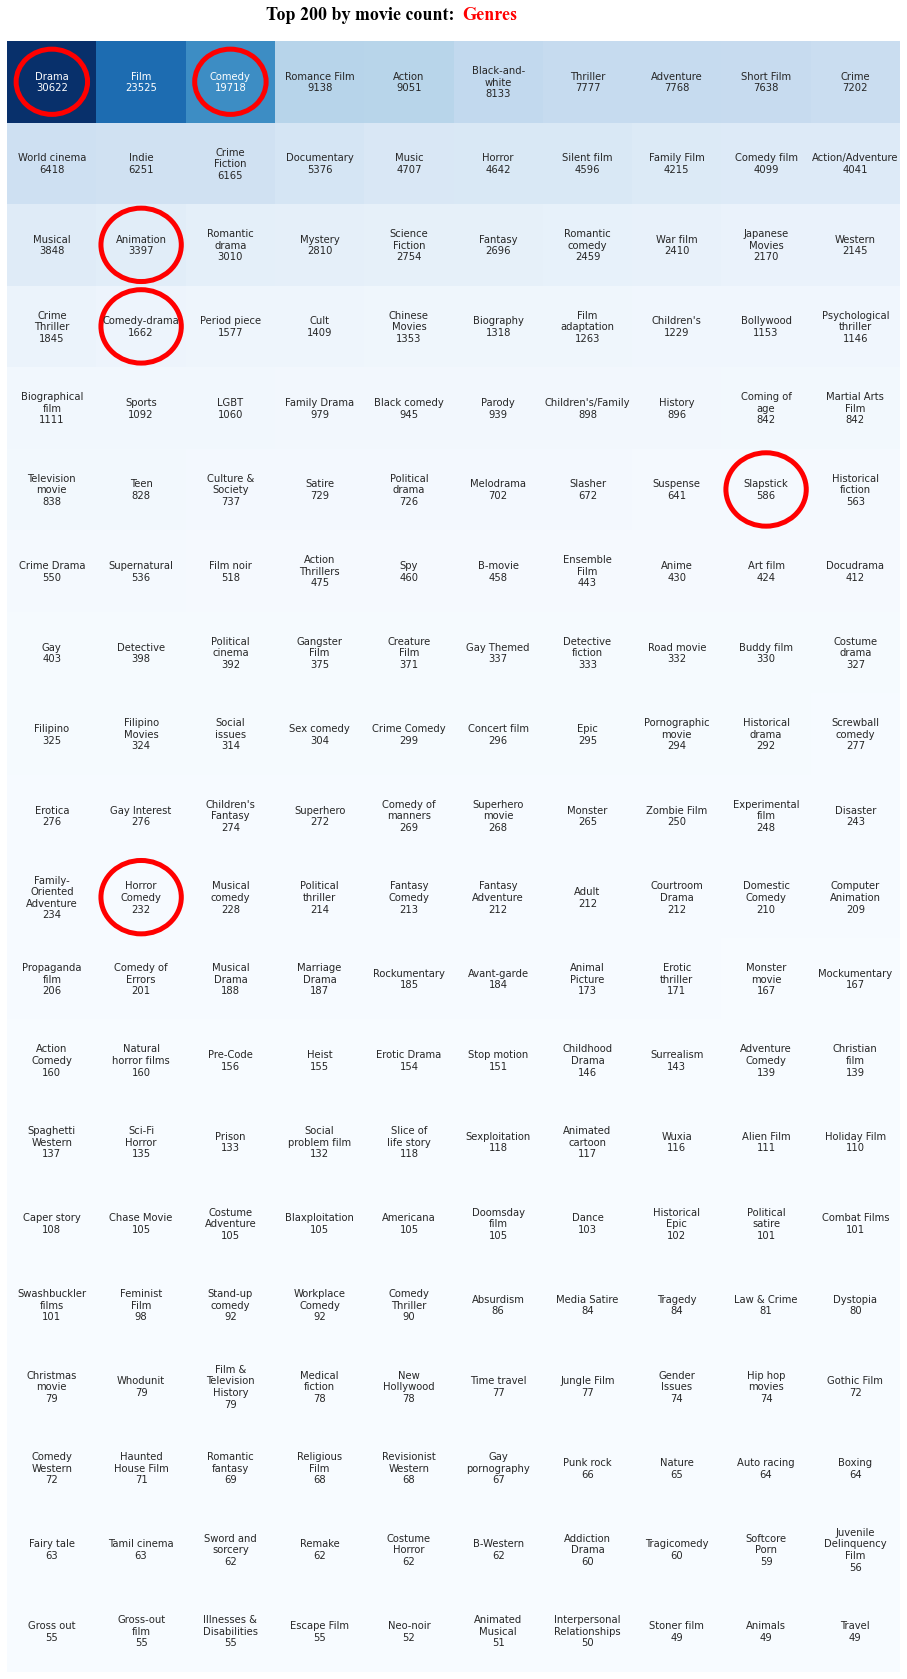

In [34]:
%run EDA_Functions.ipynb
wiki_id_genre, genre_list_listed = working_with_genre(summary_meta33)
genre_count_rev_df = count_movies_avg_revenue_per_cat(wiki_id_genre,genre_list_listed,"genres")
# genre_count_rev_df.to_excel("genre_count_rev_df.xlsx")
labels, movie_count_np = seaborn_count_plot(genre_count_rev_df, 200,20,10)
genre_heat(movie_count_np,labels)

That's a lot of genres! The next step is to look at the frequency of movies across genres. Understandably,most of the movie have been tagged to multiple genres. A heatmap is therefore plotted for top 200 genres. The calculated data is exported as an excel file for reference (see *genre_count_rev_df* ).It can be seen that tags like "Drama" and "film" have the highest number of movies tagged to them, however they cant be considered genres.Also, there are lots of similar genres such as "Comedy","Comedy Drama","Slapstick" etc.Certain tags are a combination of genres such as "Horror Comedy" (scroll down in the plot) which makes it difficult to classify them as "Horror" or "Comedy". Tags such as "Silent Film", "Animation" convey more about the medium of the movie than the plot and so on. <br>
Similar genres were therefore clubbed and too specific or too ambiguous genres were dropped. Tags such as animation and documentary would be created as movie attributes.

In [35]:
%run EDA_Functions.ipynb
wiki_id_genre = club_and_drop(wiki_id_genre)

The same operation is performing on country (see exported excel file *country_count_rev_df*) Below is a plot of top 140 countries by frequency of movies.

Number of unique countries:  145


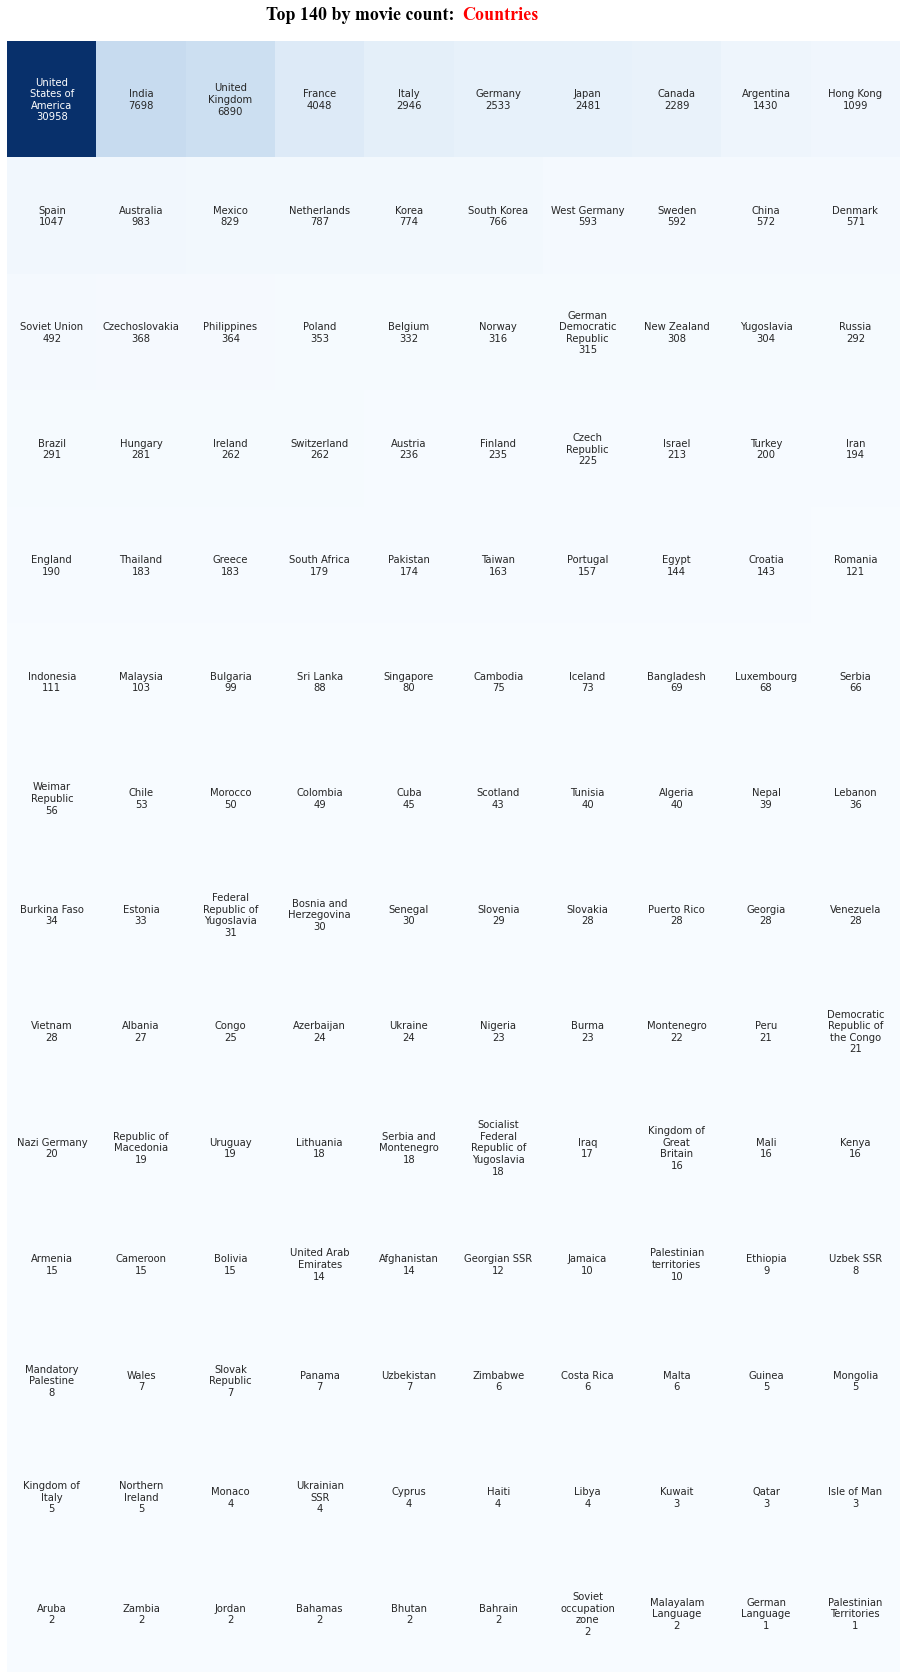

In [36]:
%run EDA_Functions.ipynb
wiki_id_countries , country_list_listed = working_with_countries(summary_meta33)
country_count_rev_df = count_movies_avg_revenue_per_cat(wiki_id_countries,country_list_listed,"countries")
labels, movie_count_np = seaborn_count_plot(country_count_rev_df, 140,14,10)
country_heat(movie_count_np, labels)

A bulk of the movies are from the USA ( approx. 40%), followed by India ( approx 10%). 6 of the 10 countries are from North America/Europe whereas 3 of the remaining are Asian and 1 from South America. This indicates that the dataset is biased heavily towards USA followed by Europe, given that approx. 60% of the world population lives in [Asia](https://www.worldometers.info/world-population/asia-population/#:~:text=Asia%20Population%20(LIVE)&text=Asia%20population%20is%20equivalent%20to%2059.76%25%20of%20the%20total%20world%20population.) and [India](https://www.screenaustralia.gov.au/fact-finders/international-context/world-rankings/in-the-archive/films-produced) consistently produces the highest number of movies in the world every year . 
Binary flags for top 20 countries by movie counts are retained whereas the remaning countries are grouped into regions.   

In [37]:
%run EDA_Functions.ipynb
wiki_id_countries = club_and_drop_country(wiki_id_countries)

Finally, the same exercise is performed for languages. See *language_count_rev_df* for frequencies by language. Let's look at the heatmap for languages as well.

Count of languages:  197


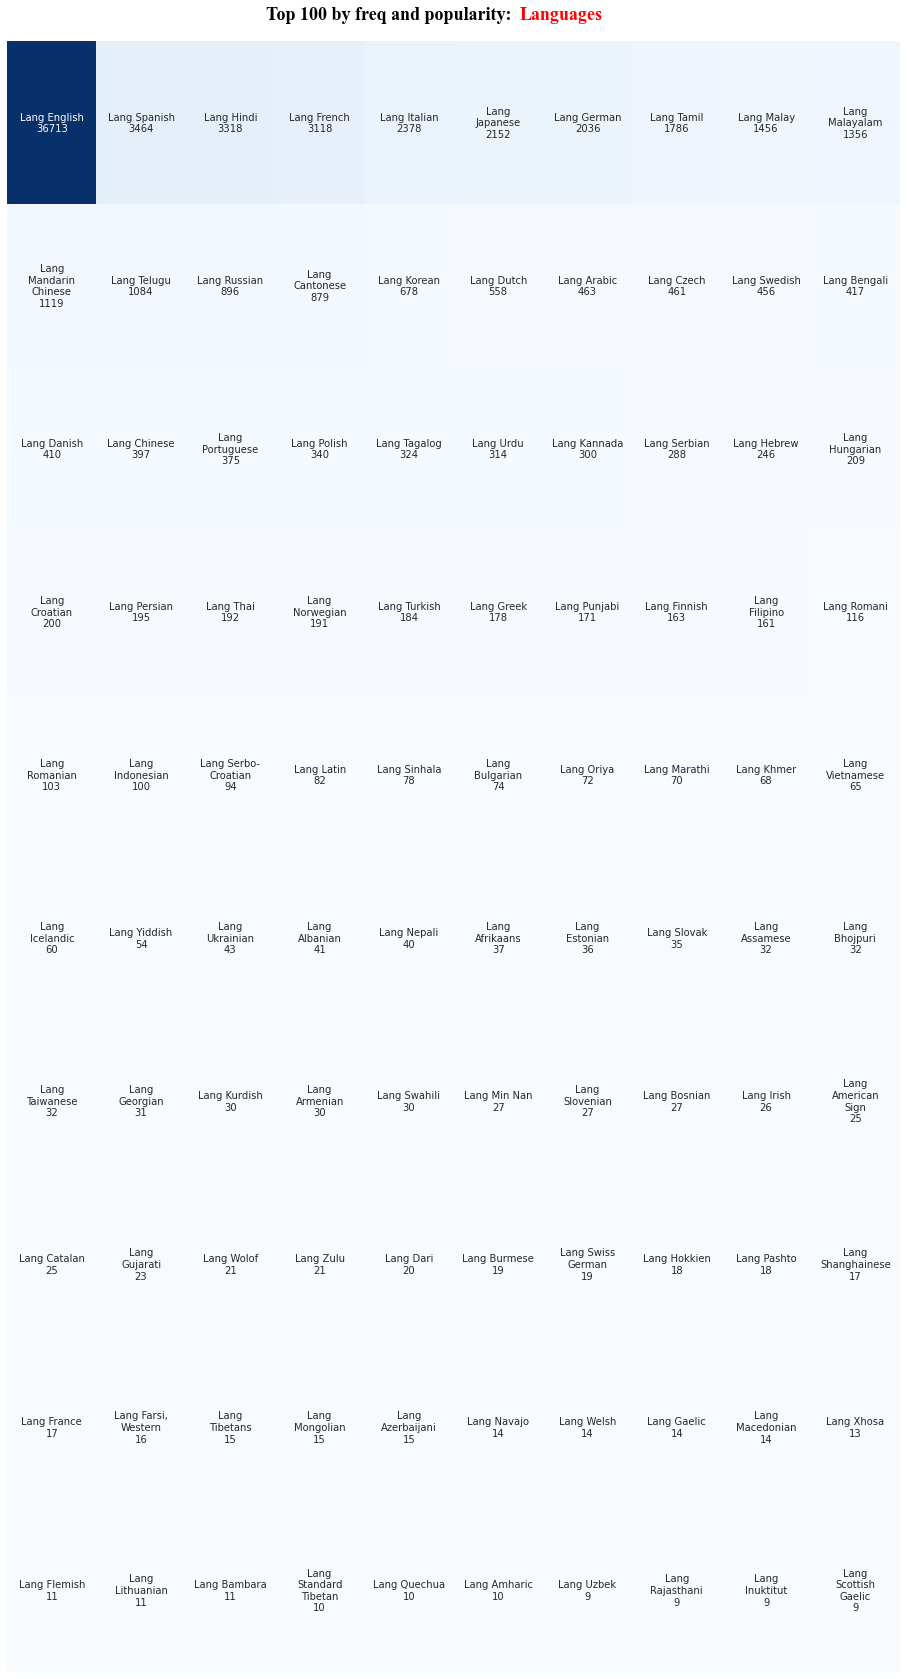

In [38]:
%run EDA_Functions.ipynb
wiki_id_languages, lang_val_list_listed = working_with_languages(summary_meta33)
language_count_rev_df = count_movies_avg_revenue_per_cat(wiki_id_languages,lang_val_list_listed,"languages")
# language_count_rev_df.to_excel("language_count_rev_df.xlsx")
labels, movie_count_np = seaborn_count_plot(language_count_rev_df, 100,10,10)
languages_heat(movie_count_np, labels)

No prizes for guessing that English again takes the top spot, followed by Spanish, Hindi etc. A mix of most frequent languages in the data and [the most spoken languages of the world](https://www.babbel.com/en/magazine/the-10-most-spoken-languages-in-the-world) was used to create the final list of 20 languages for which binary flags would be retained.

In [39]:
wiki_id_languages = wiki_id_languages[['wiki_id','Lang English', 'Lang Spanish', 'Lang Hindi', 'Lang French', 
                                       'Lang Italian','Lang Japanese', 'Lang Danish','Lang Portuguese',
                                       'Lang German', 'Lang Tamil', 'Lang Malay', 'Lang Malayalam', 'Lang Telugu', 
                                       'Lang Mandarin Chinese', 'Lang Russian', 'Lang Arabic', 'Lang Bengali','Lang Polish',
                                      'Lang Tagalog','Lang Urdu']]

print("Final list of Languages: ",wiki_id_languages.columns[1:].values)

Final list of Languages:  ['Lang English' 'Lang Spanish' 'Lang Hindi' 'Lang French' 'Lang Italian'
 'Lang Japanese' 'Lang Danish' 'Lang Portuguese' 'Lang German'
 'Lang Tamil' 'Lang Malay' 'Lang Malayalam' 'Lang Telugu'
 'Lang Mandarin Chinese' 'Lang Russian' 'Lang Arabic' 'Lang Bengali'
 'Lang Polish' 'Lang Tagalog' 'Lang Urdu']


The flags thus defined are joined back to the main dataset. At this point, any row with missing revenue information is purged.

In [40]:
summary_meta33= summary_meta33.merge(wiki_id_genre,left_on='wiki_id',right_on='wiki_id',how='left')
summary_meta33= summary_meta33.merge(wiki_id_countries,left_on='wiki_id',right_on='wiki_id',how='left')
summary_meta33= summary_meta33.merge(wiki_id_languages,left_on='wiki_id',right_on='wiki_id',how='left')

summary_meta33_with_bo = summary_meta33[~summary_meta33['final_revenue'].isna()]
print("Data available with Revenue information: ",len(summary_meta33_with_bo)) #8742


Data available with Revenue information:  8742


## EDA: Revenue distributions by genres, countries and languages
Boxplots were created to observe the revenue distributions along with frequency annotations across respective categories

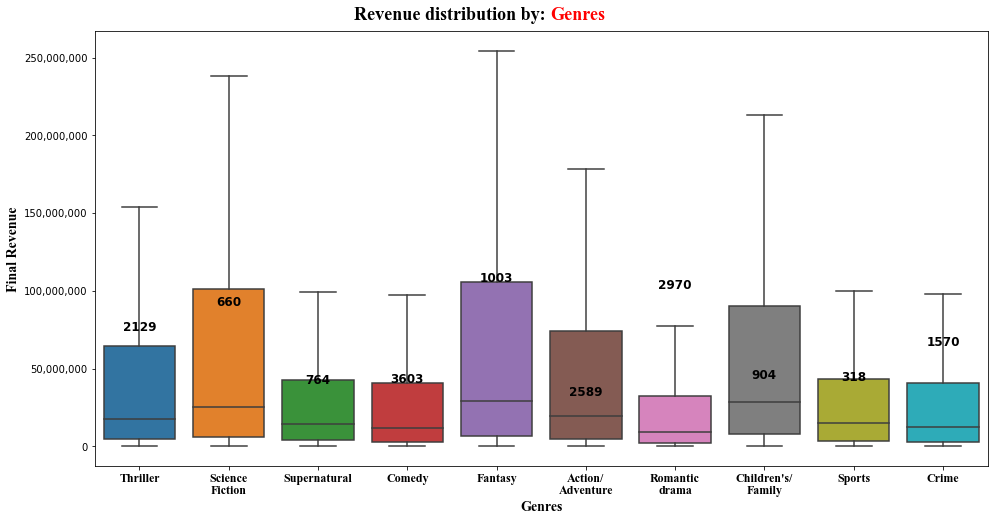

In [41]:
%run EDA_Functions.ipynb
final_genre_list = ['Thriller', 'Science Fiction','Supernatural', 'Comedy', 'Fantasy', 'Action/ Adventure',
       'Romantic drama', "Children's/ Family", 'Sports', 'Crime']

final_country_list = ['United States of America', 'India', 'United Kingdom', 'France',
       'Italy', 'Germany', 'Japan', 'Canada', 'Argentina', 'Hong Kong',
       'Spain', 'Australia', 'Mexico', 'Netherlands', 'Korea', 'Sweden',
       'China', 'Denmark', 'Middle East', 'Asia', 'Africa',
       'Southern Eastern Europe', 'South Central America', 'Carribean']

final_country_shortforplot_list = ['United States of America', 'India', 'United Kingdom', 'France',
       'Italy', 'Germany','Argentina', 'Hong Kong','Australia', 'Mexico',
       'China', 'Middle East', 'Asia', 'Africa',
       'Southern Eastern Europe', 'South Central America', 'Carribean']

final_language_list = ['Lang English', 'Lang Spanish', 'Lang Hindi', 'Lang French', 'Lang Italian','Lang Japanese',
                       'Lang Danish','Lang Portuguese','Lang German', 'Lang Tamil', 'Lang Malay', 'Lang Malayalam', 
                       'Lang Telugu','Lang Mandarin Chinese', 'Lang Russian', 'Lang Arabic', 'Lang Bengali',
                       'Lang Polish','Lang Tagalog','Lang Urdu']

df_ = boxplot_by_cat_for_revenue(final_genre_list, summary_meta33_with_bo,"Genres")

Comedy eats the humble pie with comparatively lower revenue earnings inspite of having the highest frequencies.  Animation, on the other hand, has the biggest range with almost a tenth of the frequency of Comedy. Fantasy and Science Fiction also appear to have higher earnings and are almost at par. Interestingly, the median earnings of Thriller, supernatural, comedy are almost the same indicating that there are some thrillers outperformed at some point and widened the range.

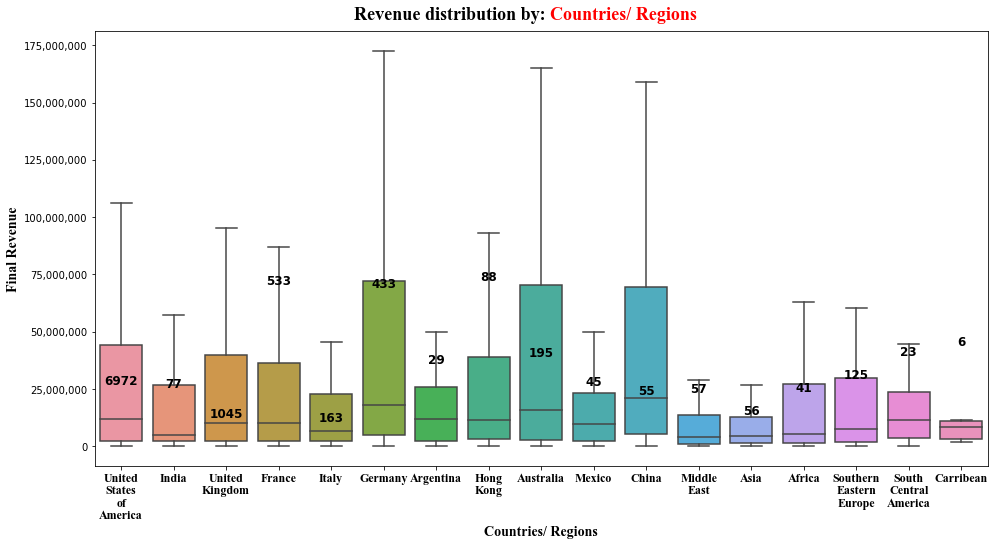

In [42]:
df_ = boxplot_by_cat_for_revenue(final_country_shortforplot_list, summary_meta33_with_bo,"Countries/ Regions")

The western world is observed to have a higher range (with the exception of China, though it only has 55 movies and it could be a biased sample) which may be indicative of a higher spending power in those countries.

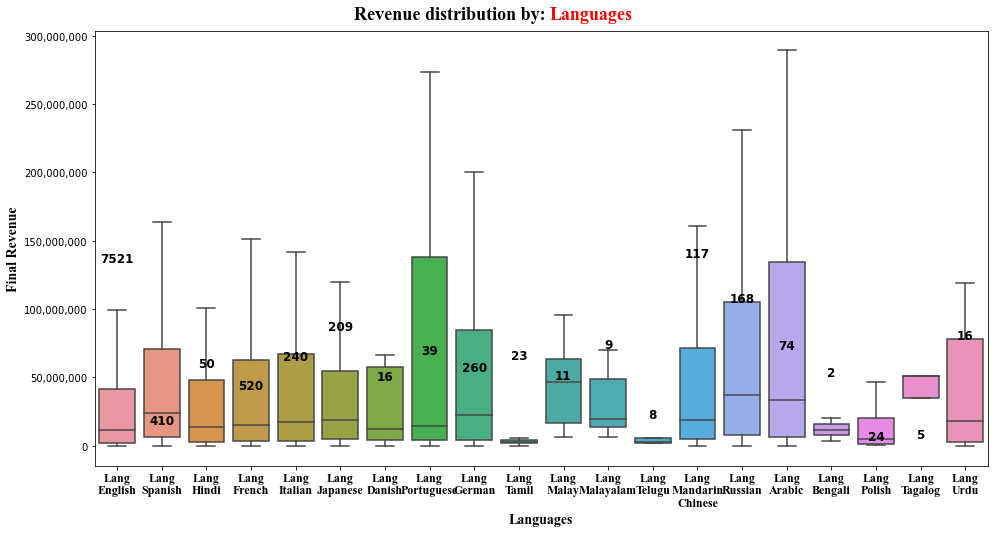

In [43]:
df_ = boxplot_by_cat_for_revenue(final_language_list, summary_meta33_with_bo,"Languages")

Portuguese and Arabic have very high percentiles compared to English, Spanish etc. As the movies are a lot fewer, a biased sample might also be at play here. From the analysis so far, it appears that the genre, country and language have an effect on the movie's earnings.

## Movie cast information
The actor table contains important details about the starcast in the movies; their DoB, gender, height, ethnicity and their age when the movie was released. Although Character names are mentioned, there is no information about whether the actor was a lead or a supporting actor. It is assumed that all actors in the movie had equivalent roles. The actor table is joined with the movie summary table to subset information of relevant movies.

In [44]:
actor_meta = pd.read_csv(r"C:\Users\Antarlina Mukherjee\Documents\Studies\Sem 3\4. Advanced Business Analytics\Amazon\summary\MovieSummaries\character.metadata.tsv",sep='\t',header=None,
                           names=['wiki_id','freebase_id','release_date','character_name','actor_dob','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age','Freebase_character_actor_map_ID','Freebase_character_ID','Freebase_actor_ID'])

actor_meta= actor_meta.merge(summary_meta33_with_bo[['wiki_id','final_revenue']],left_on='wiki_id',right_on='wiki_id',how='inner')
print("Count of rows in actor metadata for relevant movies: ",len(actor_meta))
actor_meta.head(n=1).T

Count of rows in actor metadata for relevant movies:  100050


,0
wiki_id,975900
freebase_id,/m/03vyhn
release_date,2001-08-24
character_name,Akooshay
actor_dob,1958-08-26
actor_gender,F
actor_height,1.62
actor_ethnicity,NaN
actor_name,Wanda De Jesus
actor_age,42.0


The next step was to pull actor information about movies which have non missing BOX Office earnings, and create some summaries at movies level and count of male actors, count of female actors, average age of male actor, average age of female actor and some summary statistics of average revenue of movies for the top 20 actors.

## EDA: Actors by gender, revenue, age and genre

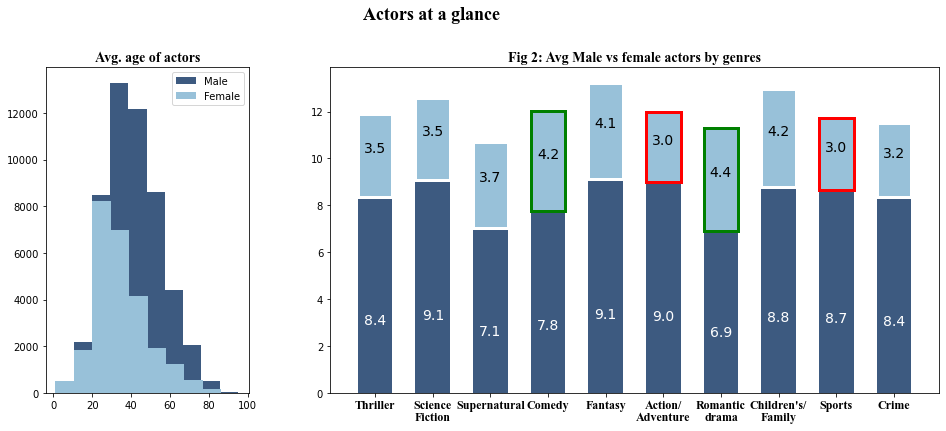

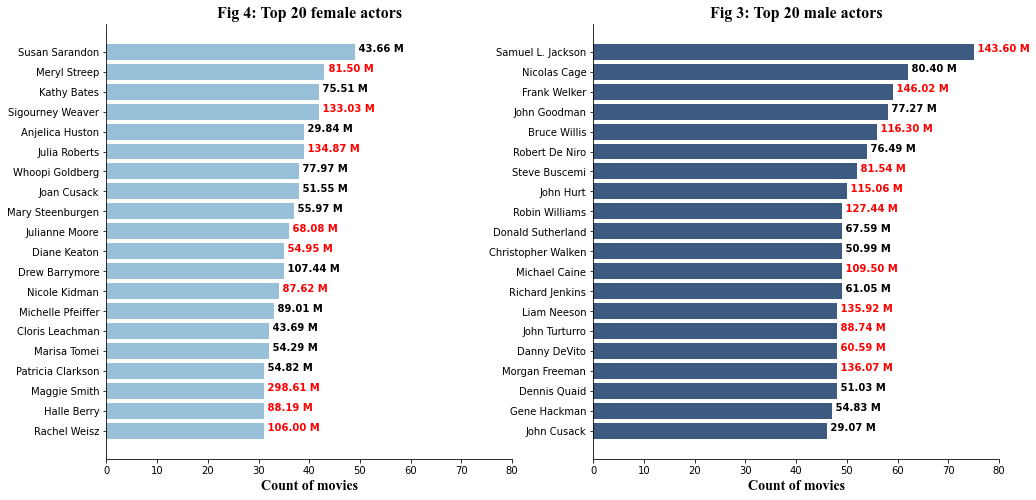

In [45]:
top_male, top_female = actor_dashboard(summary_meta33_with_bo, actor_meta)

It is seen that female actors(see Figure 1) are at their peak in their twenties post which they is a gradual decline. Male actors on the other hand are at their peak in their theirties. The gap in frequencies between the genders is huge in the thirties although both see a steady decline. <br>
<br>
Female actors have the highest presence in romantic movies(see Figure 2) or comedies but have very little presence in action and crime movies. Also,there is a huge gap between the male presence( approx. 7) and female presence ( approx. 3) which further affirms the patriarchal nature of the industry.
Figure 3 and 4 show that the horizontal axis range for female actors is almost half as that of male actors indicating that a lower on-screen presence compared to male actors. Also, the average revenue earnings of 3 of top 5 male actors is higher than that of female actors. Ofcourse, a movie can have both male and female actors however, the gap in the movie revenues of the top 5 actors (to the tune of approx. 50%) are indicative of a pattern. <br>
<br>
Lastly, the frequency and earnings of male actors appear to vary directly( more movies means more revenue) whereas the revenue earnings for female actors is quite haphazard. The lack of a pattern might just be indicating that the volatility in their movie earnings.  
<br>
Considering the above, flags of top 20 male and female actors(by frequency), avg age of male actor while release, avg age of female actor while release, avg count of male actors, avg count of female actors are calculated. Also calculated are some calendar variables such as years since release and month flags of year of release.

In [46]:
%run EDA_Functions.ipynb
summary_meta33_with_bo,final_month_list = actor_and_calendar_calculated_fields(actor_meta, summary_meta33_with_bo,top_male,top_female)
summary_meta33_with_bo.describe().T

,count,mean,std,min,25%,50%,75%,max
wiki_id,8606.0,9.483636e+06,1.040256e+07,3217.0,1357023.75,4455638.5,16034045.5,3.732211e+07
runtime,8606.0,1.019022e+02,2.750865e+01,0.0,91.00,101.0,113.0,5.720000e+02
final_revenue,8606.0,4.302671e+07,9.972695e+07,8736.0,2250000.00,10334866.5,37827234.0,2.782275e+09
Thriller,8606.0,2.455264e-01,4.304239e-01,0.0,0.00,0.0,0.0,1.000000e+00
Science Fiction,8606.0,7.587729e-02,2.648171e-01,0.0,0.00,0.0,0.0,1.000000e+00
...,...,...,...,...,...,...,...,...
release_mon_8.0,8606.0,7.099698e-02,2.568347e-01,0.0,0.00,0.0,0.0,1.000000e+00
release_mon_9.0,8606.0,9.307460e-02,2.905538e-01,0.0,0.00,0.0,0.0,1.000000e+00
release_mon_10.0,8606.0,7.727167e-02,2.670375e-01,0.0,0.00,0.0,0.0,1.000000e+00
release_mon_11.0,8606.0,5.995817e-02,2.374231e-01,0.0,0.00,0.0,0.0,1.000000e+00


## Plot summaries
The last (but not the least) is the plot summaries that are available in the CMU data. First, let's import it and clean it up. The code has a runtime of 30 mins hence it is commented and a previously saved version of the file is being imported and consumed instead.

In [47]:
summary = pd.read_csv("summary\MovieSummaries\plot_summaries.txt",sep='\t',header=None,names=['wiki_id','summaryText'])
summary_meta33_with_bo = summary_meta33_with_bo.merge(summary[['wiki_id','summaryText']],
                             left_on='wiki_id', right_on='wiki_id', how='inner')
print("Count of movie summaries: ",len(summary))
print("Count of movie titles with revenue AND plot summary: ",len(summary_meta33_with_bo))
summary.head(n=1).T

Count of movie summaries:  42303
Count of movie titles with revenue AND plot summary:  7498


,0
wiki_id,23890098
summaryText,"Shlykov, a hard-working taxi driver and Lyosha..."


In [48]:
# summary_meta33_with_bo['summary_clean'] = summary_meta33_with_bo['summaryText'].apply(clean_up)
summary_text_cleaned = pd.read_csv("summary_cleaned.csv")
summary_meta33_with_bo = summary_meta33_with_bo.merge(summary_text_cleaned[['wiki_id','summary_clean']],
                                                      left_on='wiki_id',right_on='wiki_id',how='left')
summary_meta33_with_bo = summary_meta33_with_bo.dropna(subset=['summary_clean'])
summary_meta33_with_bo[['summaryText','summary_clean']].head(n=1).T

,0
summaryText,"Set in the second half of the 22nd century, th..."
summary_clean,second half century depicts planet terraformed...


In [49]:
# summary_meta33_with_bo['summary_clean'] = summary_meta33_with_bo['summaryText'].apply(clean_up)

## EDA: WordClouds of plot summaries
The following are wordclouds by the bag of words approach across the genres

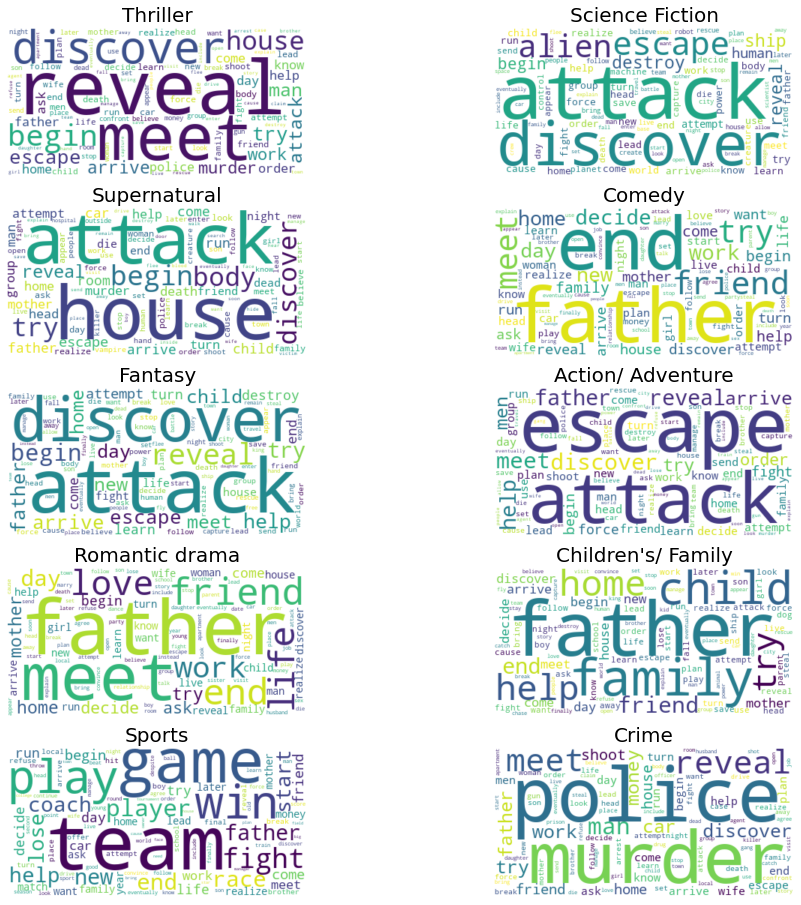

In [50]:
%run EDA_Functions.ipynb
genre_wordclouds_from_text(genre_list_listed,summary_meta33_with_bo)

Thrillers seem to be about reveal or discovering which makes sense. Science fiction, fantasy and Action/ Adventure share their popular words. The word "house" differentiates Supernatural from them indicating a potential haunted house setting in the movies. Comedy has very generic words, which is not very indicative of its type ( this could be a potential problem in predicting this class). Also, Romantic drama and Children's movies seem to have a big overlap making them indistinguishable. Lastly, Sports and Crime capture "team, game" and "Police, murder" respectively which is very typical of the respective genres. <br>
<br>
It may be interesting to observe the **TF-IDF** based wordclouds and look for unique patterns in the respective genres.

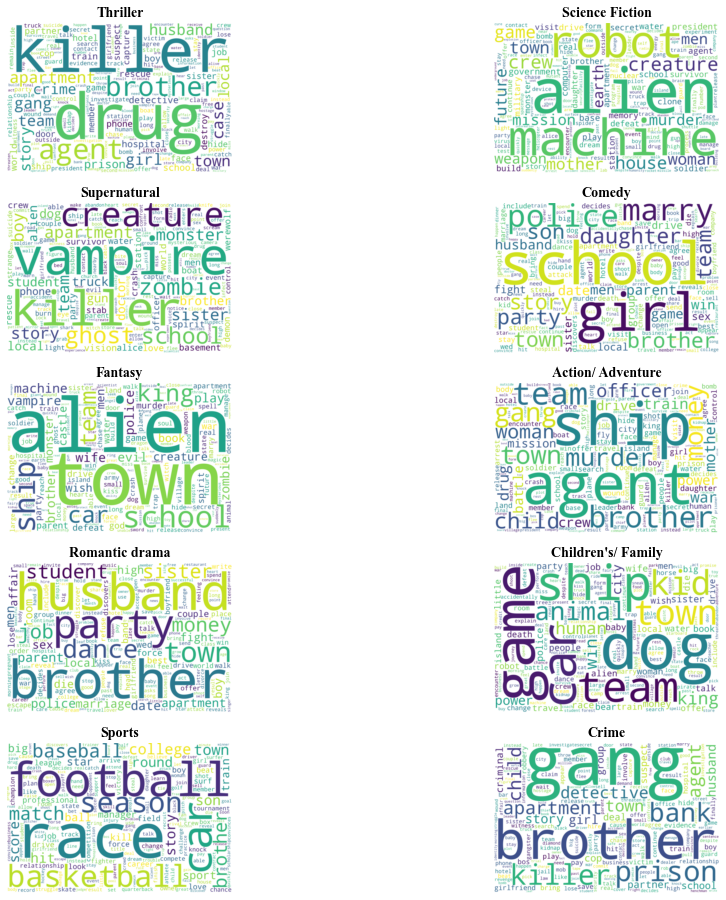

In [51]:
%run EDA_Functions.ipynb
genre_wordclouds_from_tfidf(final_genre_list,summary_meta33_with_bo)

Each of the wordclouds above are excellent representation of most of the genres. The lines between romantic drama, comedy and childrens movies are still a blur. <br>

## Data preparation for research questions
Before starting the preprocessing of data, it may be a good idea to look at the histograms of the discrete and continuous variables

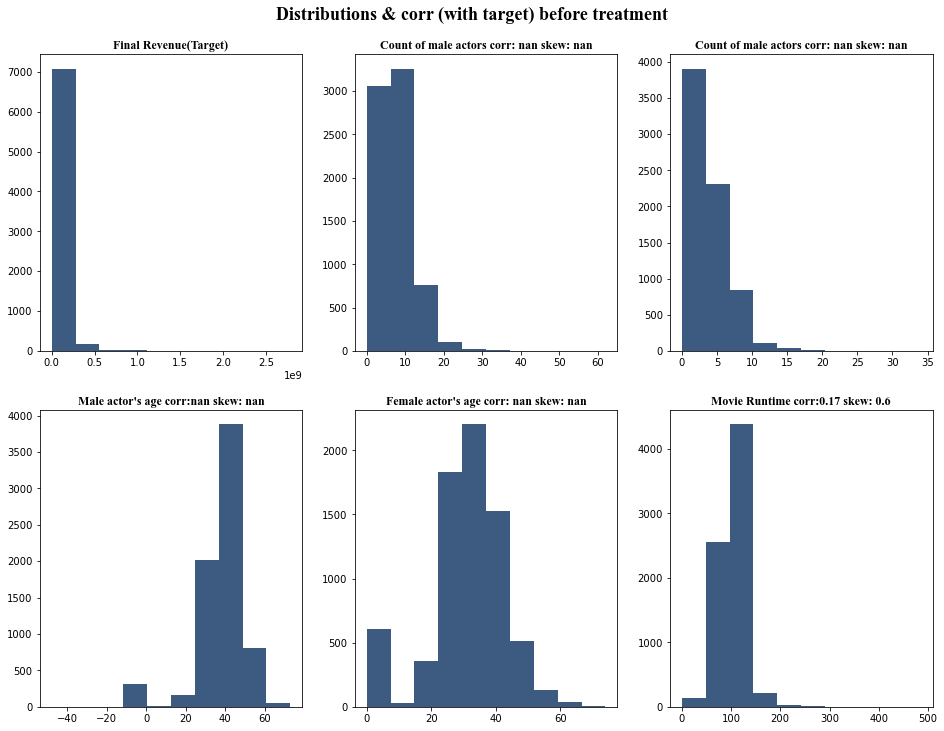

In [52]:
%run EDA_Functions.ipynb
histograms_for_summary_meta33(summary_meta33_with_bo,"Distributions & corr (with target) before treatment")

It is safe to say that all the fields have a skewed distribution.Also the correlation is NaN due to missing values. Missing value imputation is thus performed below and capping and flooring is performed in an attempt to handle the outliers.

In [53]:
%run EDA_Functions.ipynb
summary_meta33_with_bo = capping_and_flooring(summary_meta33_with_bo,top_male,top_female)

final_rev_cap: 329699645.0   final_rev_flr: 2000000.0  avg rev: 11849116.0
male actor cap: 22.0   female actor cap: 12.0  avg male count: nan  avg female count: nan
avg male age cap: 72.0 avg female age cap: 68.0
avg male age flr: nan avg female age flr: nan
runtime cap: 177.0  runtime floor: 40


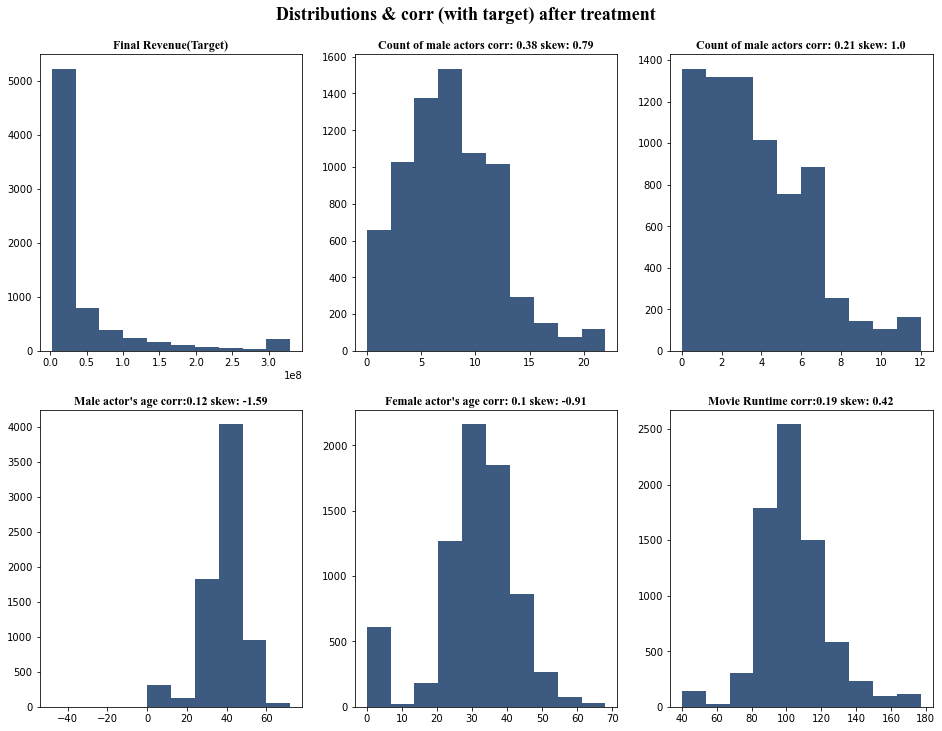

In [54]:
%run EDA_Functions.ipynb
histograms_for_summary_meta33(summary_meta33_with_bo,"Distributions & corr (with target) after treatment")

It can be seen that the sknewness has reduced a bit however the correlations are quite low. (It is worth mentioning that log transforms of the variables were also taken and experimented with but were rolled back as there was no significant improvement in results) <br>
**To summarise:** Various information with regards to movies, such as their plot summary, their cast, demographic details about the cast, movie runtime, genre, language, region etc.have been analysed so far and plausible relationship between plot summaries and genre and that between genre, star cast and revenue have also been observed. It is therefore time to reflect on the first reason questions.

In [55]:
all_predictor_list = ['release_year_before_2000','male_count','female_count','avg_male_age','avg_female_age','runtime']
all_predictor_list = all_predictor_list+list(final_month_list)+list(final_genre_list)+list(final_country_list)+list(final_language_list)+list(top_male)+list(top_female)
print("Count of predictor variables: ",len(all_predictor_list))

Count of predictor variables:  111


## Question 1: Predicting genre based on plot summaries
As seen in the wordclouds , TFIDF seems to grasp the intuition of the movie genre(s) based on the plot summary. Therefore there may be an opportunity to predict genres based on a summary of the movie using a predictive model without any human intervention. It must be borne in mind that one plot can belong to multiple genres hence it is a `Multi label classification` task. The following approaches are explored for the prediction task  in this report:

    - Dummy classification ( Baseline)
    - TF-IDF based Latent Dirichlet Allocation
    - Word Embeddings based LSTM
    

# Model 0 : Dummy classification
The prediction is based on the percent distribution of each class. So if a genre is present in 30% of the movies then an array of a random combination 1 and 0 is created while preserving the percentage

In [56]:
from sklearn.metrics import precision_score
x= summary_meta33_with_bo[final_genre_list].values
x_sum = np.sum(x,axis=0)
print(x_sum)
# x_total = np.sum(np.sum(x,axis=0))
# print(x_total)
x_prob = x_sum/len(summary_meta33_with_bo)
print(x_prob)
# np.sum(x,axis=0)
y_array = []
for x_prob in x_prob:
    nums = [np.random.choice([0, 1], size=len(x), p=[1-x_prob, x_prob])]
    y_array=y_array+nums
    
y_array1 = np.asmatrix(y_array).T
# y_array1.shape
# initialize:
tp = 0; fp = 0; tn = 0; fn = 0;
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if x[i,j] == y_array1[i,j] & x[i,j] == 1:
            tp = tp+1
        if x[i,j] == y_array1[i,j] & x[i,j] == 0:
            tn = tn+1
        if x[i,j] == 1 & y_array1[i,j] == 0:
            fn = fn + 1
        if x[i,j] == 0 & y_array1[i,j]  == 1:
            fp = fp+ 1
print(tp,tn,fp,fn)
print("precision: ", tp/(tp+fp))
print("recall: ", tp/(tp+fn))

[1971  618  721 3226  934 2333 2603  851  268 1418]
[0.26918875 0.08440317 0.09847036 0.44059    0.12756078 0.31862879
 0.35550396 0.11622508 0.03660202 0.19366293]
4254 58277 0 47647
precision:  1.0
recall:  0.08196373865628793


### Model 1: TFIDF based LDA for genre prediction

In [57]:
%run EDA_Functions.ipynb
model1, metrics_list_tfidf = TFIDF_LDA_for_genre(summary_meta33_with_bo,final_genre_list)

(5857, 38107)
5857
(1465, 38107)
1465
n_topics:  10  type: TFIDF
46/46 [==============================] - 0s 3ms/step - loss: 0.4497 - precision: 1.0000 - recall: 3.3478e-04
n_topics:  15  type: TFIDF
46/46 [==============================] - 0s 2ms/step - loss: 0.9089 - precision_1: 0.3798 - recall_1: 0.1861
n_topics:  20  type: TFIDF
46/46 [==============================] - 0s 3ms/step - loss: 0.9251 - precision_2: 0.3802 - recall_2: 0.1865
n_topics:  25  type: TFIDF
46/46 [==============================] - 0s 3ms/step - loss: 0.9564 - precision_3: 0.3802 - recall_3: 0.1865


The results are quite poor even though the wordclouds looked promising. 

### Model 2: Word embedding based genre prediction

In [58]:
%run EDA_Functions.ipynb
word_to_vec_map = read_and_store('glove\glove.840B.300d.txt')

In [59]:
%run EDA_Functions.ipynb
glove_model,X_padded,X_train, X_test, Y_train, Y_test = embedding_layer_keras_LSTM(summary_meta33_with_bo,word_to_vec_map)

dictionary length: 38185
X train: (5857, 50)
Y train: 5857
X test: (1465, 50)
Y test: 1465
Embedding matrix: (38186, 300)
10
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           11455800  
                                                                 
 bidirectional (Bidirectiona  (None, 50, 128)          186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 128)          98816     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 50, 128)           16512     
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 128)          98816 

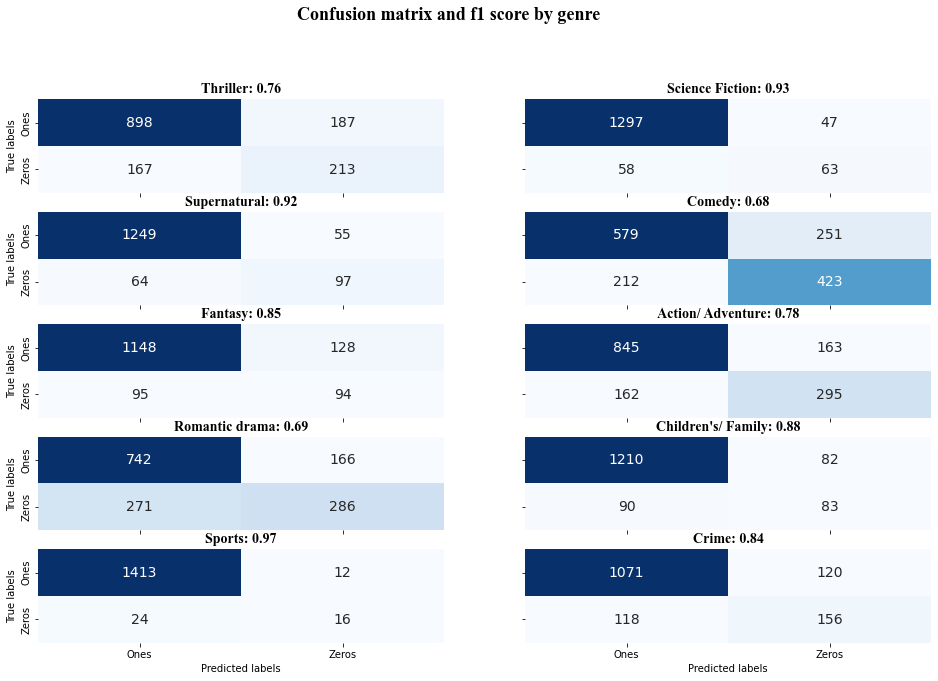

In [60]:
%run EDA_Functions.ipynb
y_pred = glove_model.predict(X_test)
confusion_matrix_LSTM_validation_genre(y_pred,Y_test)

Above is the confusion matrix subplots for the respective genres.The results obtained are quite impressive. It seems that word embeddings based LSTM neural network was better at grasping the context of the plots and thus performed the classification task better. Comedy and romantic drama faired moderately which indicates it is probably difficult to capture comedy just as a gist and has more to do with the screenplay and actor's demeanour. Also, the genre might be very dilute.<br>
<br>
This leads to the final use case of this chapter: **Revenue Prediction using Genre and other attributes**. The following methodologies are attempted for the prediction
   - Dummy Regressor
   - Linear Regression based on calculated genres and other flags
   - XGBoost based on calculated genres and other flags
   - Concatenating two neural networks (LDA and other flags)

## Model 0: Dummy Regressor

r2 score:  0.0


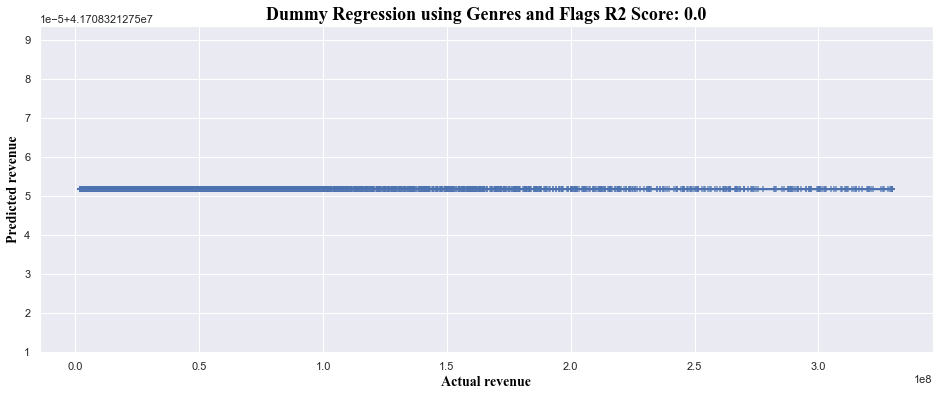

In [61]:
%run EDA_Functions.ipynb
all_predictor_list_minus_genres = ['release_year_before_2000','male_count','female_count','avg_male_age','avg_female_age','runtime',
                     'Documentary','Animation','Biography','History']
genre_headers=['Thriller','Science Fiction', 'Supernatural', 'Comedy','Fantasy','Action/ Adventure', 
               'Romantic drama',"Children's/ Family",'Sports', 'Crime']
all_predictor_list_minus_genres = all_predictor_list_minus_genres+list(final_month_list)+list(final_country_list)+list(final_language_list)+list(top_male)+list(top_female)
y_overall = glove_model.predict(X_padded)
genre_predicted = pd.DataFrame((y_overall>0.5).astype(int),columns=genre_headers)
X_df = summary_meta33_with_bo[all_predictor_list_minus_genres]
X_df= X_df.reset_index()
X_df= X_df.merge(genre_predicted,left_index=True,right_index=True,how='left')
dummy_revenue_regressor(summary_meta33_with_bo,all_predictor_list,X_df)


## Model 1: Linear Regression

X_train_stdsize:  (5857, 111)
Y_train:  (5857, 1)
X_test_stdsize:  (1465, 111)
Y_test:  (1465, 1)
r2 score:  0.2416642684868533


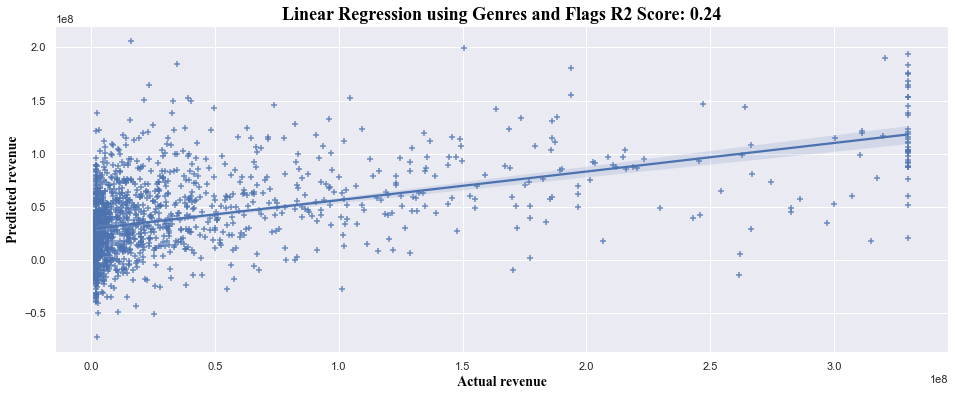

In [63]:
%run EDA_Functions.ipynb
linear_regression_revenue(X_df,summary_meta33_with_bo,all_predictor_list)

The model performed better than the dummy model hence it may be concluded that the predictors are meaningful.

## Model 2 : XGBoost

X_train_stdsize:  (5857, 111)
Y_train:  (5857, 1)
X_test_stdsize:  (1465, 111)
Y_test:  (1465, 1)
Mean MAE: 40696642.954 (2959946.479)
r2 score:  0.31921443420721474


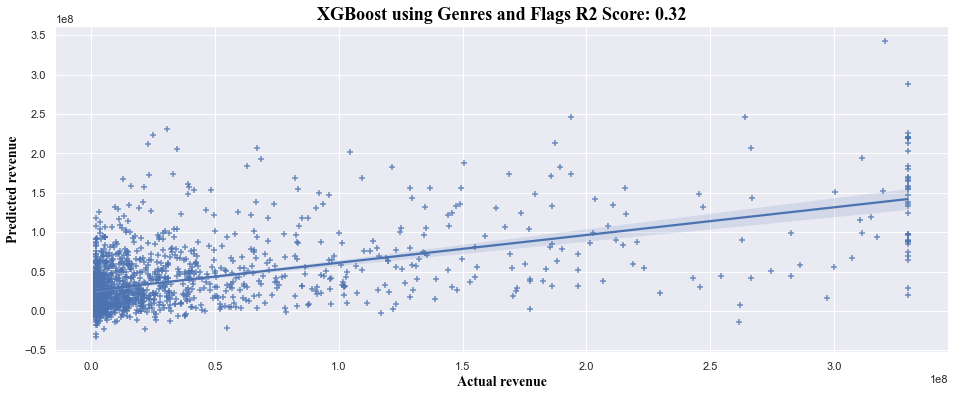

In [64]:
%run EDA_Functions.ipynb
xgc,X_mean, X_std,X_train, X_test ,y_train , y_test,X_train_stdize,X_test_stdize = XGBoost_revenue(X_df,summary_meta33_with_bo)
y_xgc = xgc.predict(X_test_stdize)
plt.figure(figsize=(16,6))
ax = sns.regplot(x=y_test, y=y_xgc,marker="+")
ax.set_xlabel("Actual revenue",fontdict={'family': 'Times New Roman', 
                    'color' : 'black',
                    'weight': 'bold',
                    'fontsize': 14})
ax.set_ylabel("Predicted revenue",fontdict={'family': 'Times New Roman', 
                    'color' : 'black',
                    'weight': 'bold',
                    'fontsize': 14})
ax.set_title("XGBoost using Genres and Flags R2 Score: "+str(np.round(r2_score(y_test, y_xgc),2)),fontdict={'family': 'Times New Roman', 
                    'color' : 'black',
                    'weight': 'bold',
                    'fontsize': 18})
plt.show()


It is observed that the results are slightly better than linear regression. Below is the feature importance plot. The most important features are related to actors,viz. count of male actors, age of male and female actors, the month of release, runtime and also release year since 2000. Genre tags couldnt find a place in the top 10 predictors which is very interesting.

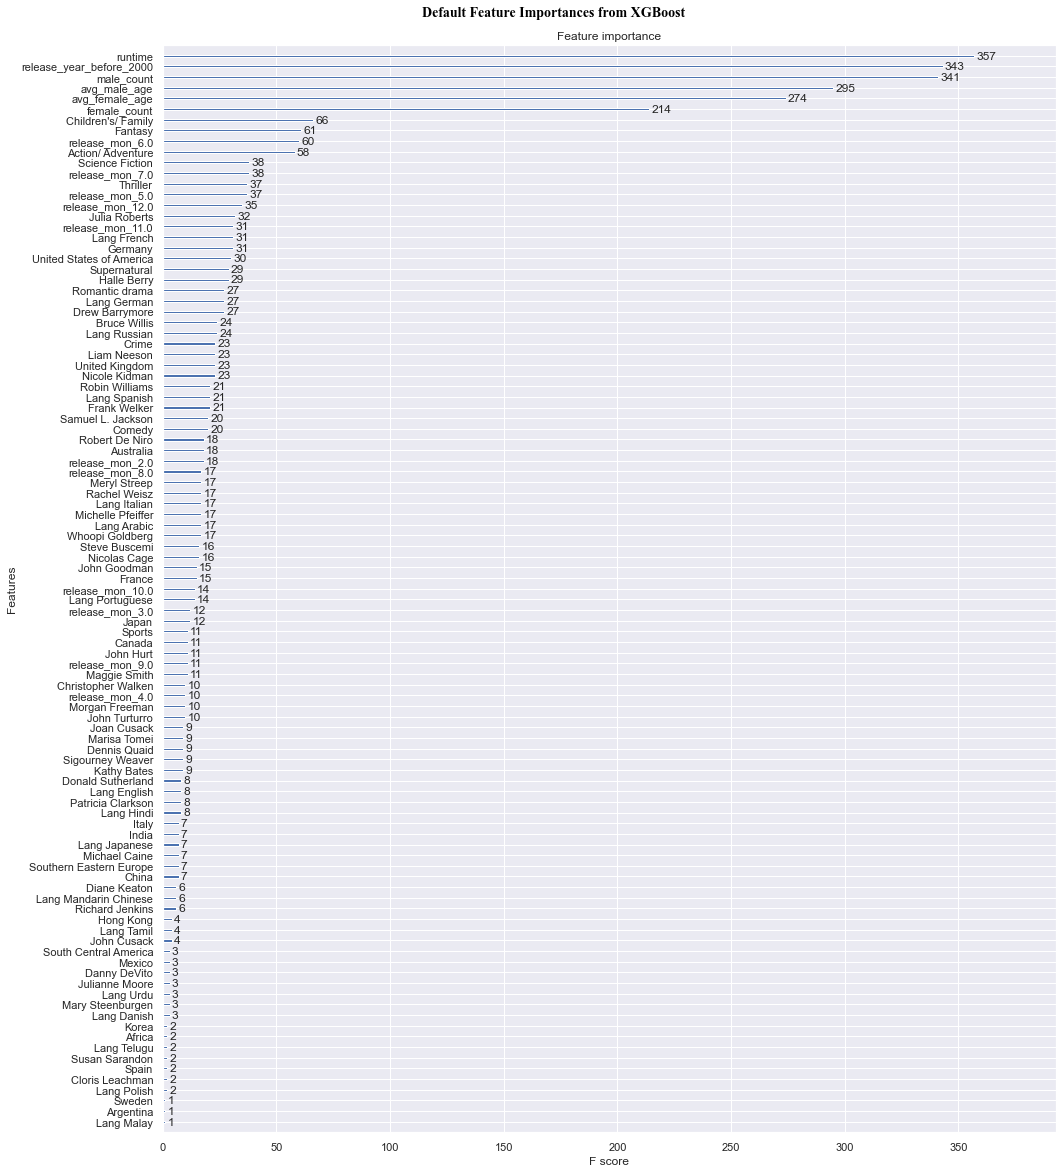

In [67]:
fig = plt.figure(figsize = (16, 20))
plt.figtext(0.35, 0.90, "Default Feature Importances from XGBoost", fontdict={'family': 'Times New Roman', 
                        'color' : 'black',
                        'weight': 'bold',
                        'size': 14})

ax1 = fig.add_subplot(1,1, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
plt.show()

In [68]:
predictions = xgc.predict(X_test_stdize)
import eli5
doc_num = 19
print('Actual Label:', y_test.loc[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test_stdize.iloc[doc_num], 
                     feature_names=all_predictor_list, show_feature_values=True)

Actual Label: final_revenue    4650000.0
Name: 19, dtype: float64
Predicted Label: -2856644.5


In [69]:
from eli5 import show_weights
show_weights(xgc, feature_names=all_predictor_list)

Weight,Feature
0.0418,Action/ Adventure
0.0390,Fantasy
0.0339,United States of America
0.0273,male_count
0.0262,release_mon_6.0
0.0200,Children's/ Family
0.0175,Julia Roberts
0.0164,Lang French
0.0161,release_year_before_2000
0.0159,release_mon_12.0


Looking at a single observation, as seen above, the count of male actors is low and since they have a very high importance they contributes very negatively towards the final prediction. Fields with less importance such as Action/Adventure contribute positively but since their importance is so low , its contribution of +474386 cannot match up to the penalty of -8842894 (male_count contribution) and hence a negative value is observed. Therefore, per this observation a Action/ Adventure with a small male cast was predicted to have poor earnings.

## Model 3: Merged neural network
The final model of the report is a merged neural network where two models are concatenated and the final output would be predicted revenues (see illustration below)
This method is intuitively different from a pipeline based approach as the learnings from the neurons of 1 model
are not lost. The learnings in the neurons of both models are utilised to make predictions.

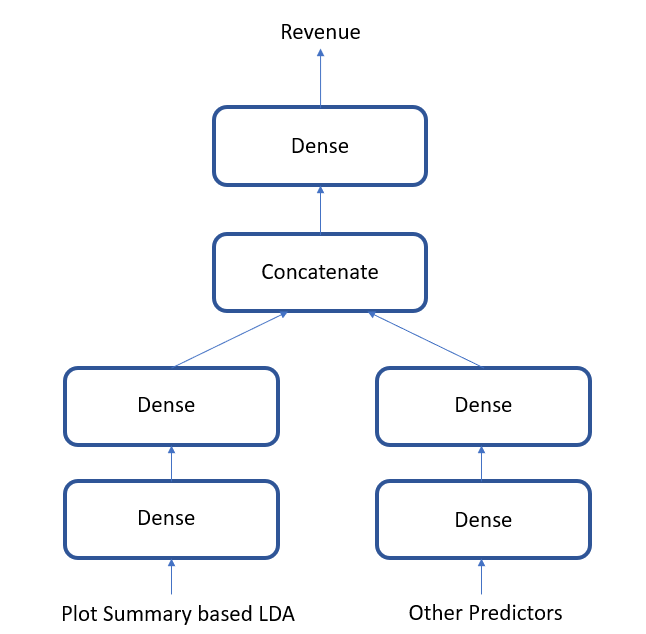

In [70]:
display.Image("merged_Arch.png",width = 600, height = 2)

In [71]:
%run EDA_Functions.ipynb
merged_model, X_bow_tfidf_lda_train, X_bow_tfidf_lda_test,y_train , y_test,input2_train, input2_test = merge_neural_network_for_revenue(summary_meta33_with_bo)

second input shape (5857, 11)
input 2 test shape (1465, 11)
size of input to model 1: 15
first input shape: (5857, 15)
5857
(1465, 15)
1465
Epoch 1/20
92/92 [==============================] - 1s 3ms/step - loss: 6776044811976704.0000 - mean_absolute_error: 41922652.0000
Epoch 2/20
92/92 [==============================] - 0s 3ms/step - loss: 6775941195890688.0000 - mean_absolute_error: 41921480.0000
Epoch 3/20
92/92 [==============================] - 0s 3ms/step - loss: 6775515994128384.0000 - mean_absolute_error: 41916772.0000
Epoch 4/20
92/92 [==============================] - 0s 3ms/step - loss: 6774465874624512.0000 - mean_absolute_error: 41905040.0000
Epoch 5/20
92/92 [==============================] - 1s 7ms/step - loss: 6772521328181248.0000 - mean_absolute_error: 41883232.0000
Epoch 6/20
92/92 [==============================] - 0s 4ms/step - loss: 6769422509277184.0000 - mean_absolute_error: 41848128.0000
Epoch 7/20
92/92 [==============================] - 0s 3ms/step - loss: 67

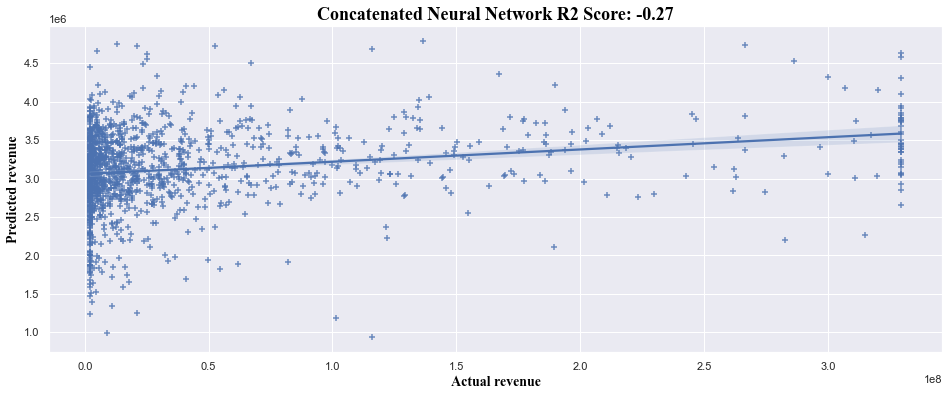

In [72]:
y_nn =merged_model.predict([X_bow_tfidf_lda_test, input2_test])
plt.figure(figsize=(16,6))
ax = sns.regplot(x=y_test, y=y_nn,marker="+")
ax.set_xlabel("Actual revenue",fontdict={'family': 'Times New Roman', 
                    'color' : 'black',
                    'weight': 'bold',
                    'fontsize': 14})
ax.set_ylabel("Predicted revenue",fontdict={'family': 'Times New Roman', 
                    'color' : 'black',
                    'weight': 'bold',
                    'fontsize': 14})
ax.set_title("Concatenated Neural Network R2 Score: "+str(np.round(r2_score(y_test, y_nn),2)),fontdict={'family': 'Times New Roman', 
                    'color' : 'black',
                    'weight': 'bold',
                    'fontsize': 18})
plt.show()

A negative r2 squared indicates worse than baseline which needs further investigation. Therefore the **XGBoost framework** provided the best results.

## Conclusions, challenges and afterthoughts:

The data explorations and the modelling activity gave an insight into the film industry and its latent features. Presence of male actors had four times the feature importance than the female counterparts in driving revenue numbers. Secondly, genres not being able to come out as top predictors may say something about people following actors than the delivered content when they go to the theaters. <br>
From a technical perspective, the biggest challenge with working with the dataset were the numerous genres which led to (too much detail and thereby noise) , the deduplication of which was upto the domain knowledge of the author. The deduplication was an ardent task and could not have been performed without undertaking secondary research but that has its limitations. Secondly, the dataset spans over almost 60 years during which the world changed a lot and so did the content of the movies. Added to it was missing revenue information which made slicing data for more recent years a challenge. Also, the data cleaning steps such as capping and flooring were performed based on certain assumptions (for the want of time) needed to be done with more deeper understanding of the data. <br> The following can be taken up as future work. Firstly the merged model for revenue prediction should be trained more rigorously (by better exploration of solution space using metaheuristics) as there is potential to get better results. Secondly, the missing revenue information should be scraped from multiple other sources to get more richness in the data. Thirdly, a clustering of the genres needs to be performed before any analysis instead of taking just an intuitive approach. Finally, the reasons for the poor performance of the LDA should be investigated. A novel approach called [LDA2vec](https://lda2vec.readthedocs.io/en/latest/) which has the power of combining the word embeddings with LDA, could generate promising results. 

## Acknowledgements:

The author of the report would like to thank Professor Francisco Pereira for giving the opportunity to work on their own choice of datasets.
TA Carolin Schmidt and TA Asger Tang deserve special mention for their innovative ideas and support throughout the project